# 任務: 爬取停車場地址、地段號、坪數、地主、停車費。

### 1. 安裝套件

In [1]:
# install google chrome
!wget https://dl.google.com/linux/linux_signing_key.pub
!sudo apt-key add linux_signing_key.pub
!echo 'deb [arch=amd64] http://dl.google.com/linux/chrome/deb/ stable main' >> /etc/apt/sources.list.d/google-chrome.list
!sudo apt-get -y update
!sudo apt-get install -y google-chrome-stable

# install chromedriver
# !apt-get install -y qq unzip
!wget -O -y /tmp/chromedriver.zip http://chromedriver.storage.googleapis.com/`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`/chromedriver_linux64.zip
!unzip -y /tmp/chromedriver.zip chromedriver -d /usr/local/bin/

# install selenium
!pip3 install selenium

# install fonts
!apt-get install -y fonts-noto

--2023-02-17 07:27:37--  https://dl.google.com/linux/linux_signing_key.pub
Resolving dl.google.com (dl.google.com)... 172.217.203.93, 172.217.203.136, 172.217.203.190, ...
Connecting to dl.google.com (dl.google.com)|172.217.203.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12415 (12K) [application/octet-stream]
Saving to: ‘linux_signing_key.pub.1’

linux_signing_key.p 100%[===================>]  12.12K  --.-KB/s    in 0s      

2023-02-17 07:27:37 (55.3 MB/s) - ‘linux_signing_key.pub.1’ saved [12415/12415]

OK
Hit:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease
Hit:2 https://dl.google.com/linux/chrome/deb stable InRelease                  
Hit:3 https://packages.cloud.google.com/apt cloud-sdk InRelease                
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]


### 2. 爬取停車場地址及停車費 (以臺北市為例)
##### *註: 車麻吉上之資訊來源為app後端資料庫，並非網路上公開之資料，一般人沒有權限用程式爬取，故先使用臺北市停車管理工程處網站的臺北市公有路外停車場資料替代。

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://pma.gov.taipei/News.aspx?n=6833ECE829BE5990&sms=504AB58CAE8A1C62&page=1&PageSize=200'

response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

cities_districts_html = soup.find_all('td', {'data-title': '行政區'})
addresses_html = soup.find_all('td', {'data-title': '停車場地址'})
fees_html = soup.find_all('td', {'data-title': '費率'})

cities_districts = [c_d.text for c_d in cities_districts_html]
cities = ['臺北市']*len(cities_districts)
districts = [c_d.split('市')[-1] for c_d in cities_districts]

addresses = [address.text for address in addresses_html]
fees = [fee.text for fee in fees_html]

# 轉成dataframe
df = pd.DataFrame({'縣市': cities, '行政區': districts, '地址': addresses, '費率':fees})

展示前10筆資料

In [3]:
df.head(10)

縣市  行政區                      地址                                    費率
0  臺北市  大安區  信義路3段134巷及建國南路2段25巷交叉口                                 計時20元
1  臺北市  內湖區           行善路266、268號地下  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
2  臺北市  信義區               大道路116號地下  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
3  臺北市  信義區                福德街86號地下  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
4  臺北市  內湖區                 金湖路46巷底                                 計時20元
5  臺北市  大同區            民族西路303巷47號旁                                 計時20元
6  臺北市  文山區      福興路106巷與106巷28弄交叉口                                 計時20元
7  臺北市  北投區      三合街一段82巷與82巷61弄交叉口           一般小型車格位：計次50元，電動車停車位：計次100元
8  臺北市  信義區          福德街84巷50、56號地下      小型車：計時30元。 機車：計時10元(當日當次最高收費20元)
9  臺北市  南港區      南港路3段47巷與市民大道7段交叉口                                 計時20元

### 3. 資料處理
##### 由上可見有些地址僅是位置之描述，如兩路交叉口或某某捷運站旁等，因此需要針對這些資料進行前處理，為簡化流程先將此類資料刪除

In [4]:
def is_valid(s):
    if '號' not in s:
        return False
    chars = ['~', '(', '、', '至', '站']
    for char in chars:
        if char in s:
            return False
    return True

for idx, row in df.iterrows():
    if not is_valid(df['地址'][idx]):
        df.drop(idx, inplace=True)

df = df.reset_index(drop=True)
df.head()

縣市  行政區               地址                                    費率
0  臺北市  信義區        大道路116號地下  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
1  臺北市  信義區         福德街86號地下  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
2  臺北市  大同區     民族西路303巷47號旁                                 計時20元
3  臺北市  文山區  羅斯福路5段236巷3-3號旁                                 計次50元
4  臺北市  松山區        健康路309號地下             小型車計時30元。機車只出售月票，不提供臨時停車。

##### 把「地下」、「旁」等無用資訊刪除

In [5]:
for idx, row in df.iterrows():
    value = df['地址'][idx].split('號')[0]+'號'
    df['地址'][idx] = value
df.head()

縣市  行政區              地址                                    費率
0  臺北市  信義區         大道路116號  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
1  臺北市  信義區          福德街86號  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
2  臺北市  大同區     民族西路303巷47號                                 計時20元
3  臺北市  文山區  羅斯福路5段236巷3-3號                                 計次50元
4  臺北市  松山區         健康路309號             小型車計時30元。機車只出售月票，不提供臨時停車。

##### 把1段、2段改成一段、二段
##### 例: 羅斯福路5段 -> 羅斯福路五段

In [6]:
num2cn = {'1段':'一段', '2段':'二段', '3段':'三段', '4段':'四段', '5段':'五段', '6段':'六段', '7段':'七段', '8段':'八段'}

for idx, row in df.iterrows():
    for key in num2cn:
        df['地址'][idx] = df['地址'][idx].replace(key, num2cn[key])
df.head()

縣市  行政區              地址                                    費率
0  臺北市  信義區         大道路116號  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
1  臺北市  信義區          福德街86號  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
2  臺北市  大同區     民族西路303巷47號                                 計時20元
3  臺北市  文山區  羅斯福路五段236巷3-3號                                 計次50元
4  臺北市  松山區         健康路309號             小型車計時30元。機車只出售月票，不提供臨時停車。

分割地址

In [8]:
addresses = df['地址'].to_list()

roads = []

# 處理段
for idx, address in enumerate(addresses):    
    split = address.split('段')
    if len(split) > 2:
        print(split)
    elif len(split) > 1:
        roads.append(split[0]+'段')
    else:
        roads.append(None)
    addresses[idx] = split[-1]
    
# 處理路
for idx, address in enumerate(addresses):
    split = address.split('路')
    if len(split) > 1:
        if roads[idx] is None:
            roads[idx] = split[0]+'路'
    addresses[idx] = split[-1]

# 處理號
for idx, address in enumerate(addresses):
    split = address.split('號')
    try:
        addresses[idx] = str(int(split[0]))
    except:
        addresses[idx] = None
        
nums = addresses

將資料加入dataframe

In [9]:
df.drop(columns='地址', inplace=True)
df.insert(loc=2, column='路街段', value=roads)
df.insert(loc=3, column='號', value=nums)

df = df[~df['路街段'].isnull()]
df = df[~df['號'].isnull()]

df = df.reset_index(drop=True)
df.head()

縣市  行政區  路街段    號                                    費率
0  臺北市  信義區  大道路  116  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)
1  臺北市  松山區  健康路  309             小型車計時30元。機車只出售月票，不提供臨時停車。
2  臺北市  松山區  健康路  285             小型車計時30元。機車只出售月票，不提供臨時停車。
3  臺北市  萬華區  青年路  188             小型車計時30元。機車只出售月票，不提供臨時停車。
4  臺北市  北投區  磺港路  261  小型車計時30元，機車計時10元(當日當次最高收費上限20元，隔日另計)

### 4. 查詢地段號
##### 連上地政雲網站

In [10]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument("--window-size=1920,1080")

driver = webdriver.Chrome(options=chrome_options)

url = "https://cloud.land.gov.taipei/ImmInfo/InteInfo.aspx"
driver.get(url)

截圖觀看結果

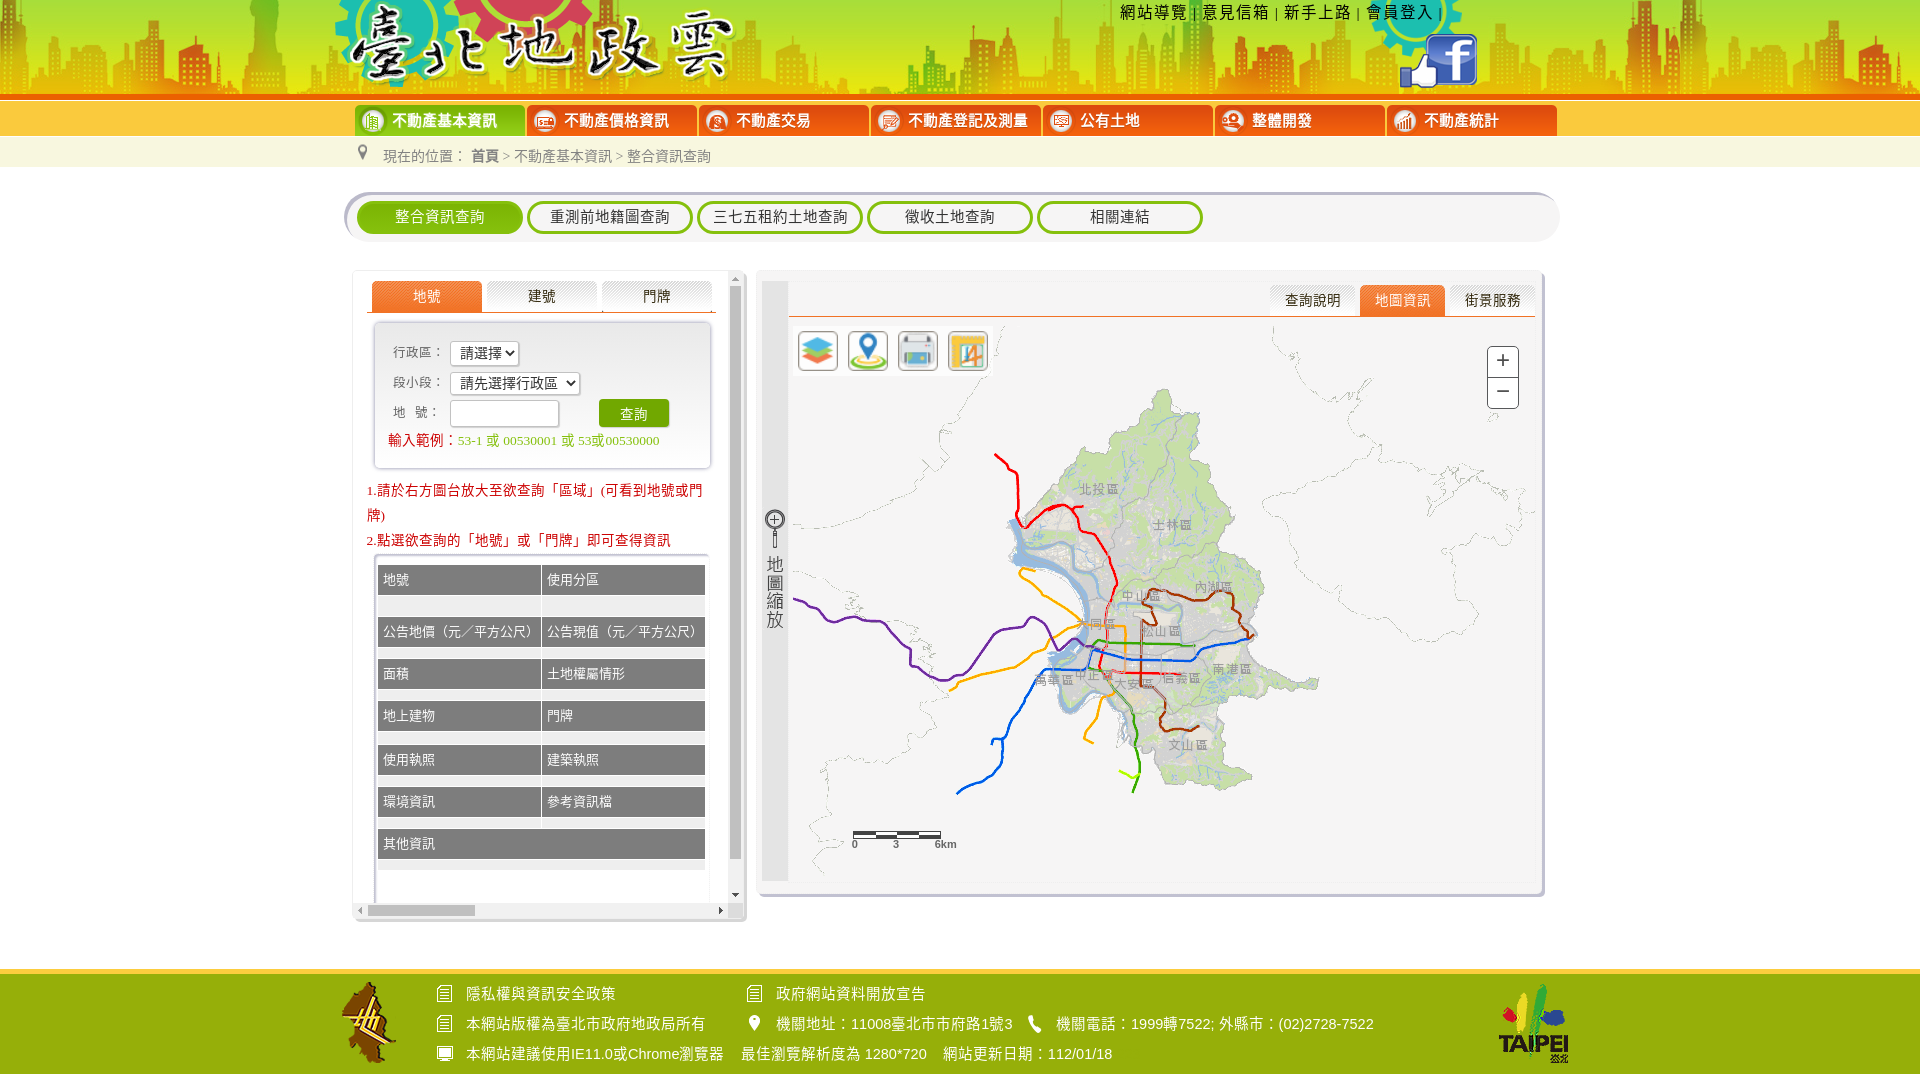

In [11]:
from PIL import Image
def prt_sc():
    driver.save_screenshot('result.png')
    img = Image.open('result.png')
    display(img)
prt_sc()

以第一筆資料為例

In [12]:
df.head(1)

縣市  行政區  路街段    號                                    費率
0  臺北市  信義區  大道路  116  小型車：計時30元，機車：計時10元(當日當次最高收費20元，隔日另計)

##### 依照步驟輸入地址

In [13]:
import time
from time import sleep
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

##### 1. 點選門牌查詢

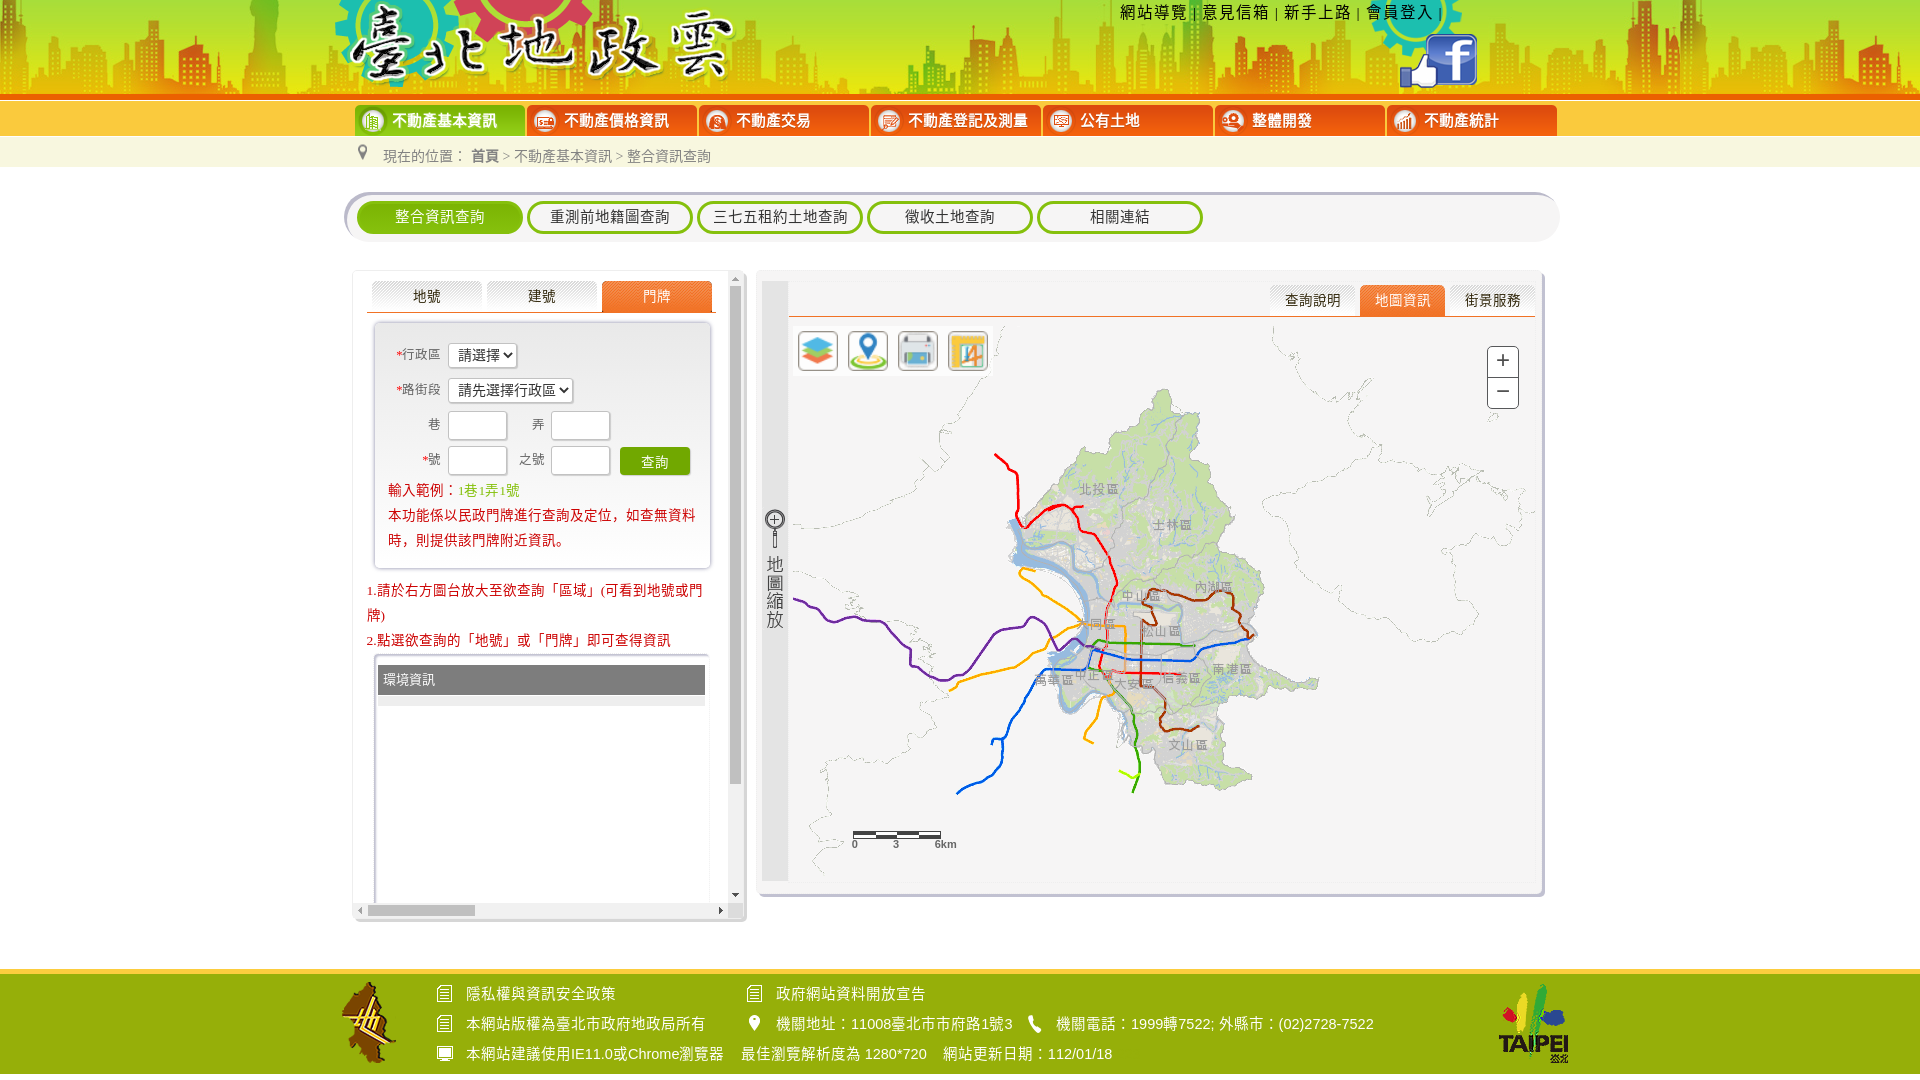

In [14]:
driver.find_element(By.XPATH, '//a[@href="#tab3"]').click()
prt_sc()

##### 2. 選取行政區

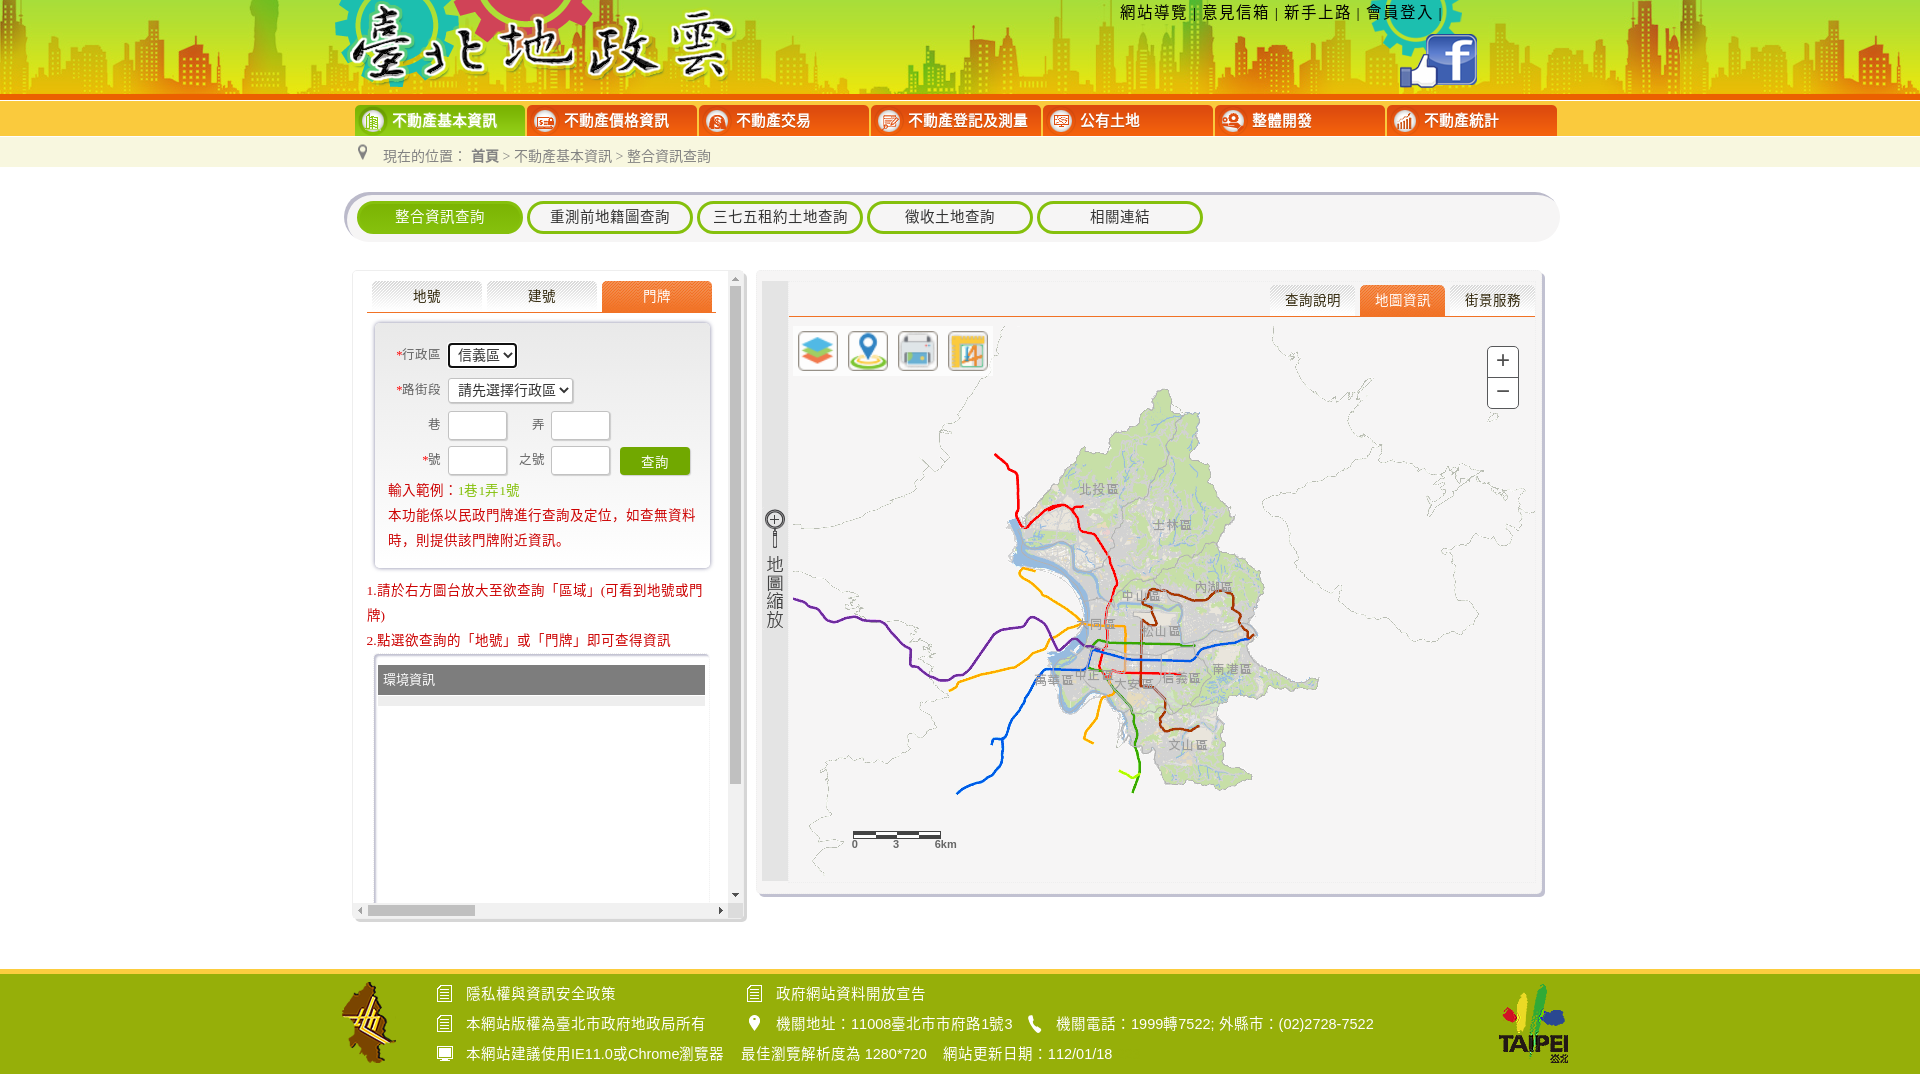

In [15]:
sleep(1)
select = Select(driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_ddl_MasterGond'))
sleep(1)
select.select_by_visible_text('信義區')
prt_sc()

##### 3. 選取路街段

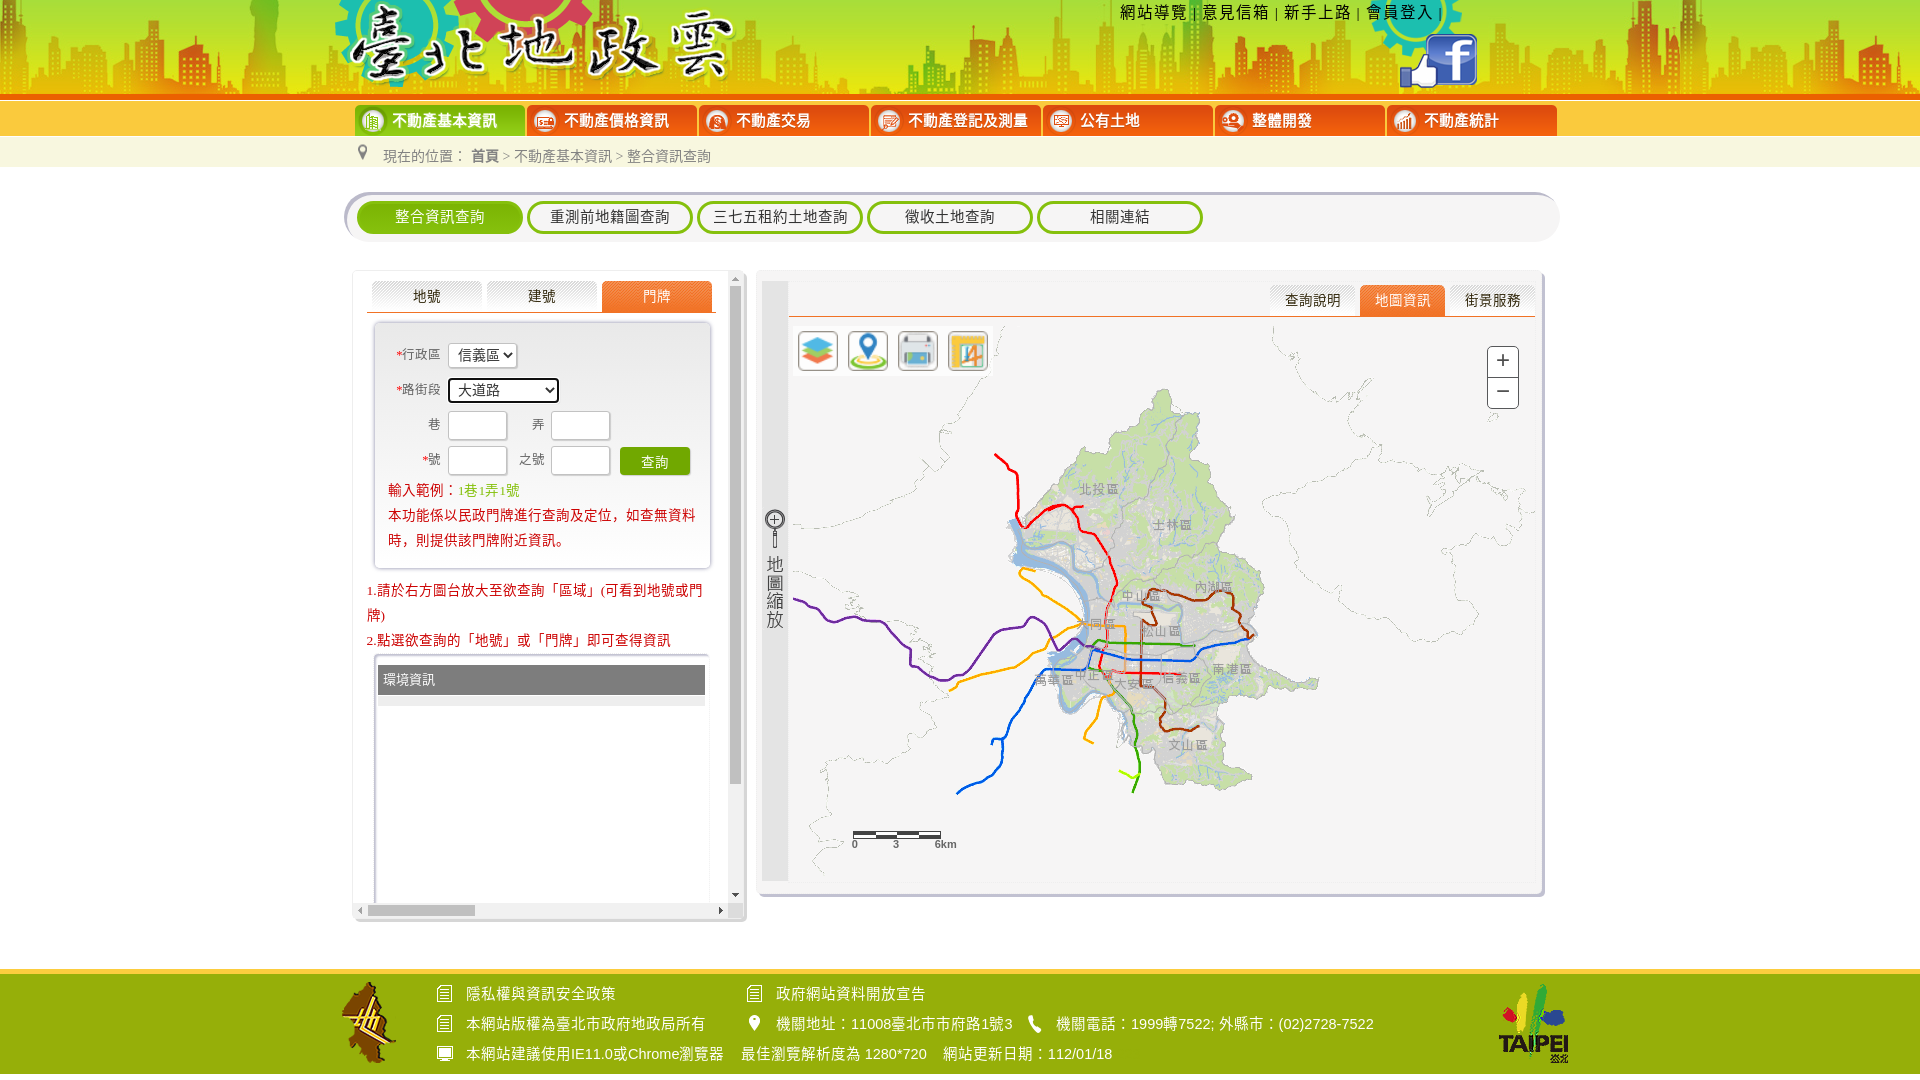

In [16]:
sleep(1)
select = Select(driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_ddl_doorNumber'))
sleep(1)
select.select_by_visible_text('大道路')
prt_sc()

##### 4. 輸入號

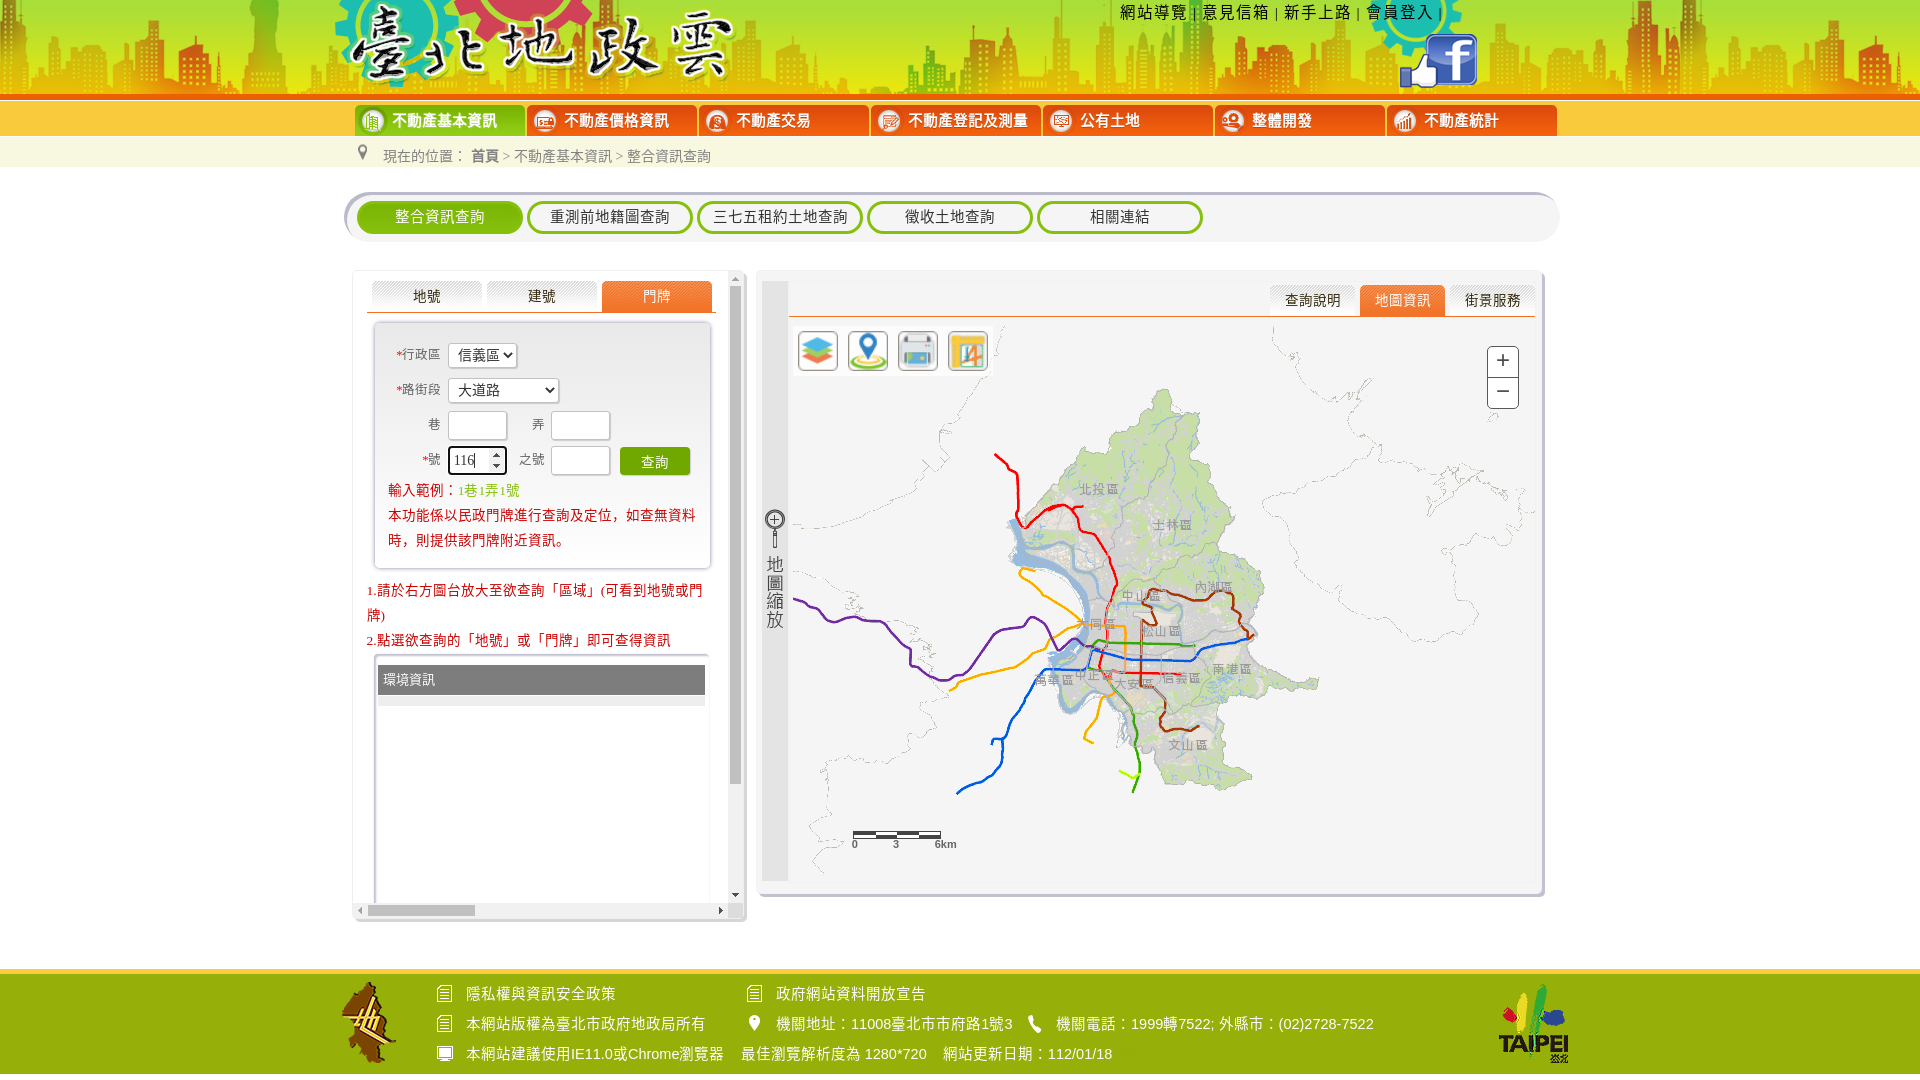

In [17]:
driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_txt_Road3').send_keys('116')
prt_sc()

##### 5. 點選查詢

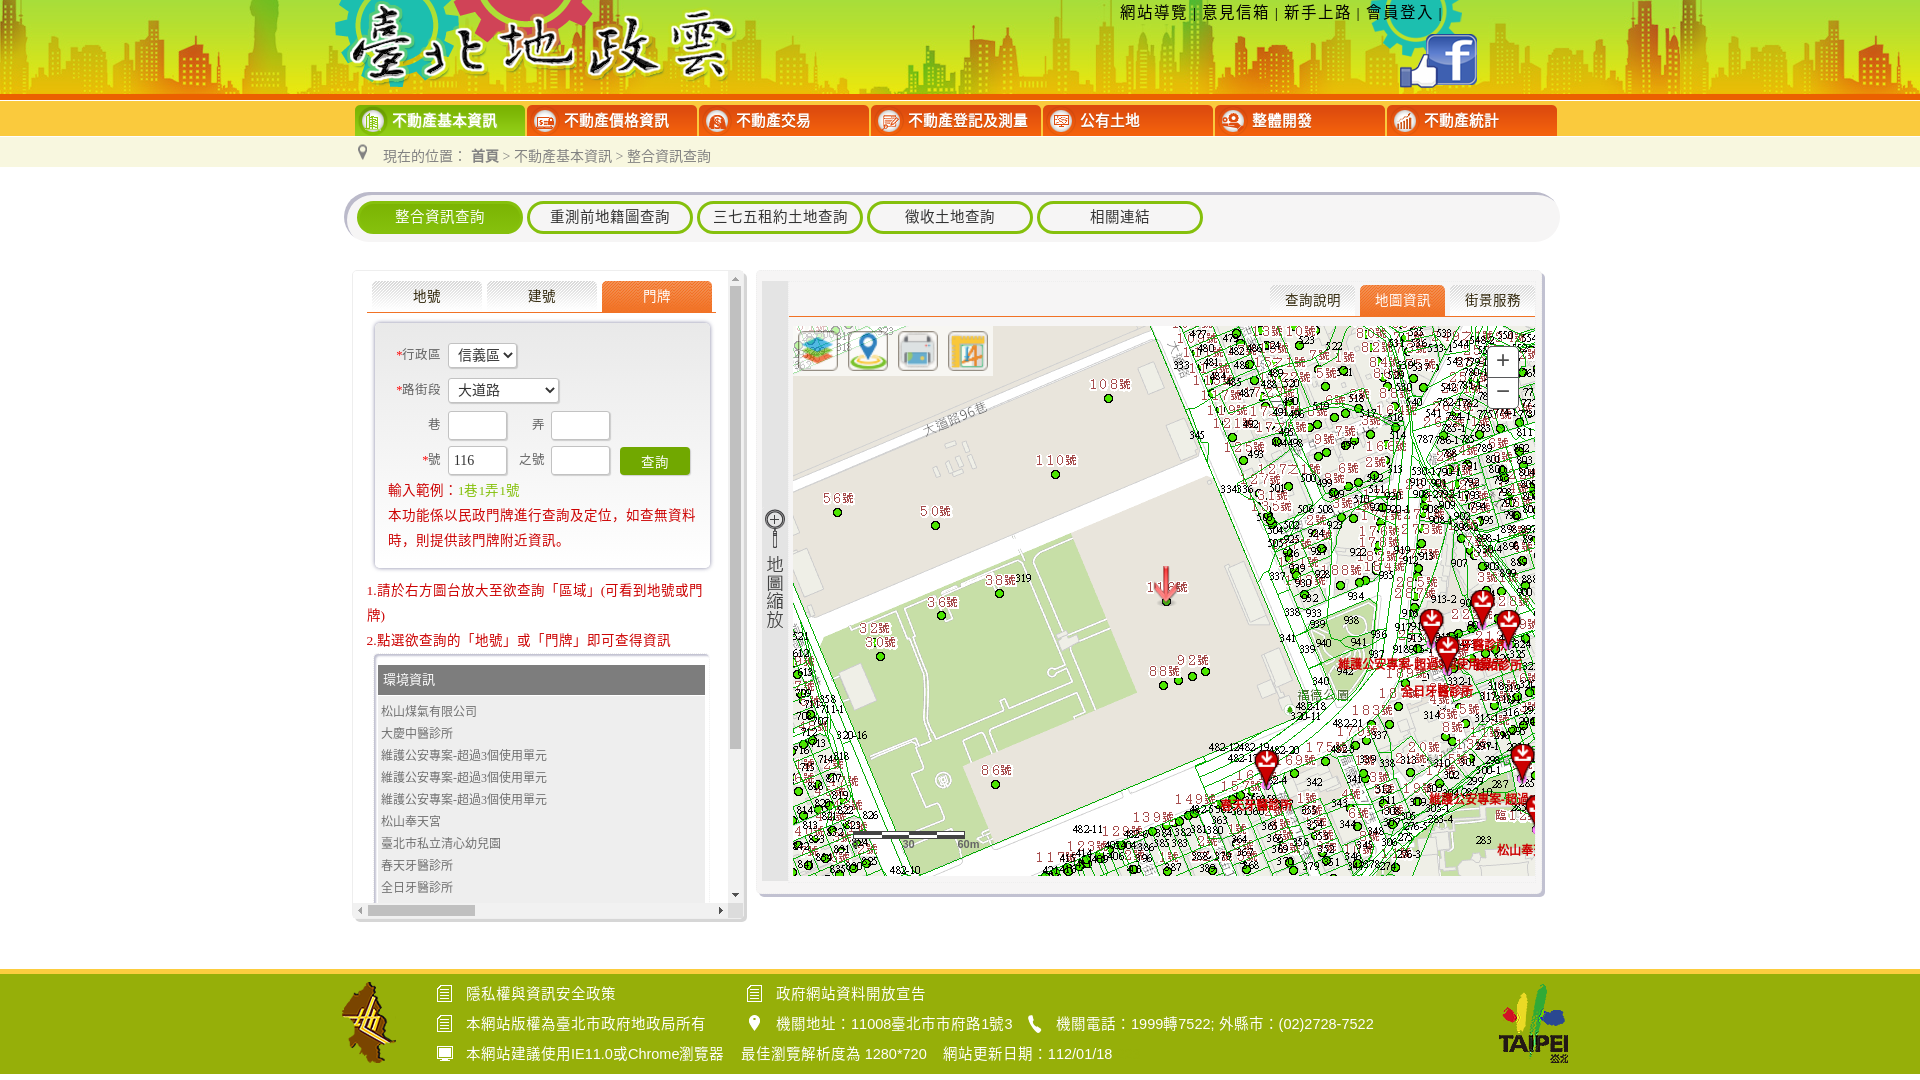

In [18]:
driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_DoorNumber_btn_Search').click()
sleep(5)
prt_sc()

##### 6. 點選標的

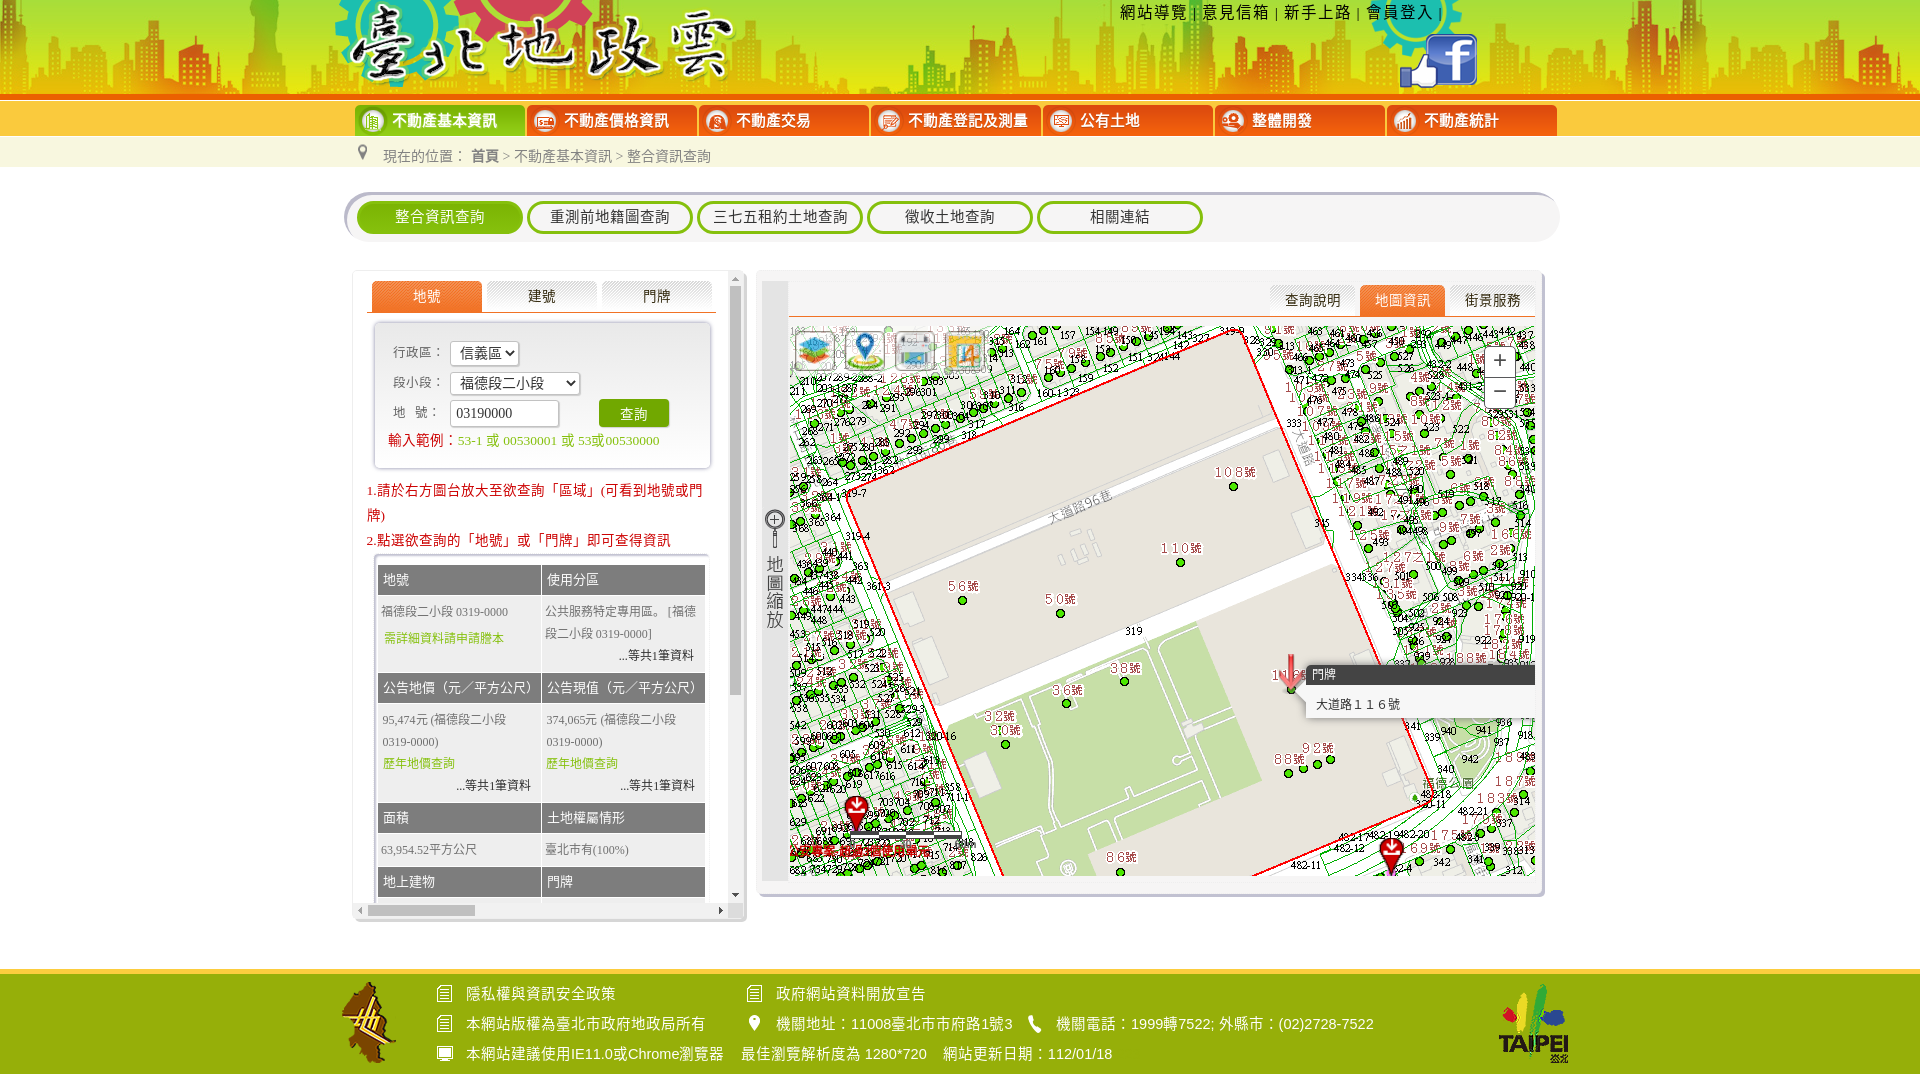

In [19]:
try:
    sleep(2)
    driver.find_element(By.ID, 'tab5').click()
    sleep(2)
except Exception as e:
    print(e)

sleep(2)    
prt_sc()

['福德段二小段', '03190000', '63,954.52平方公尺']


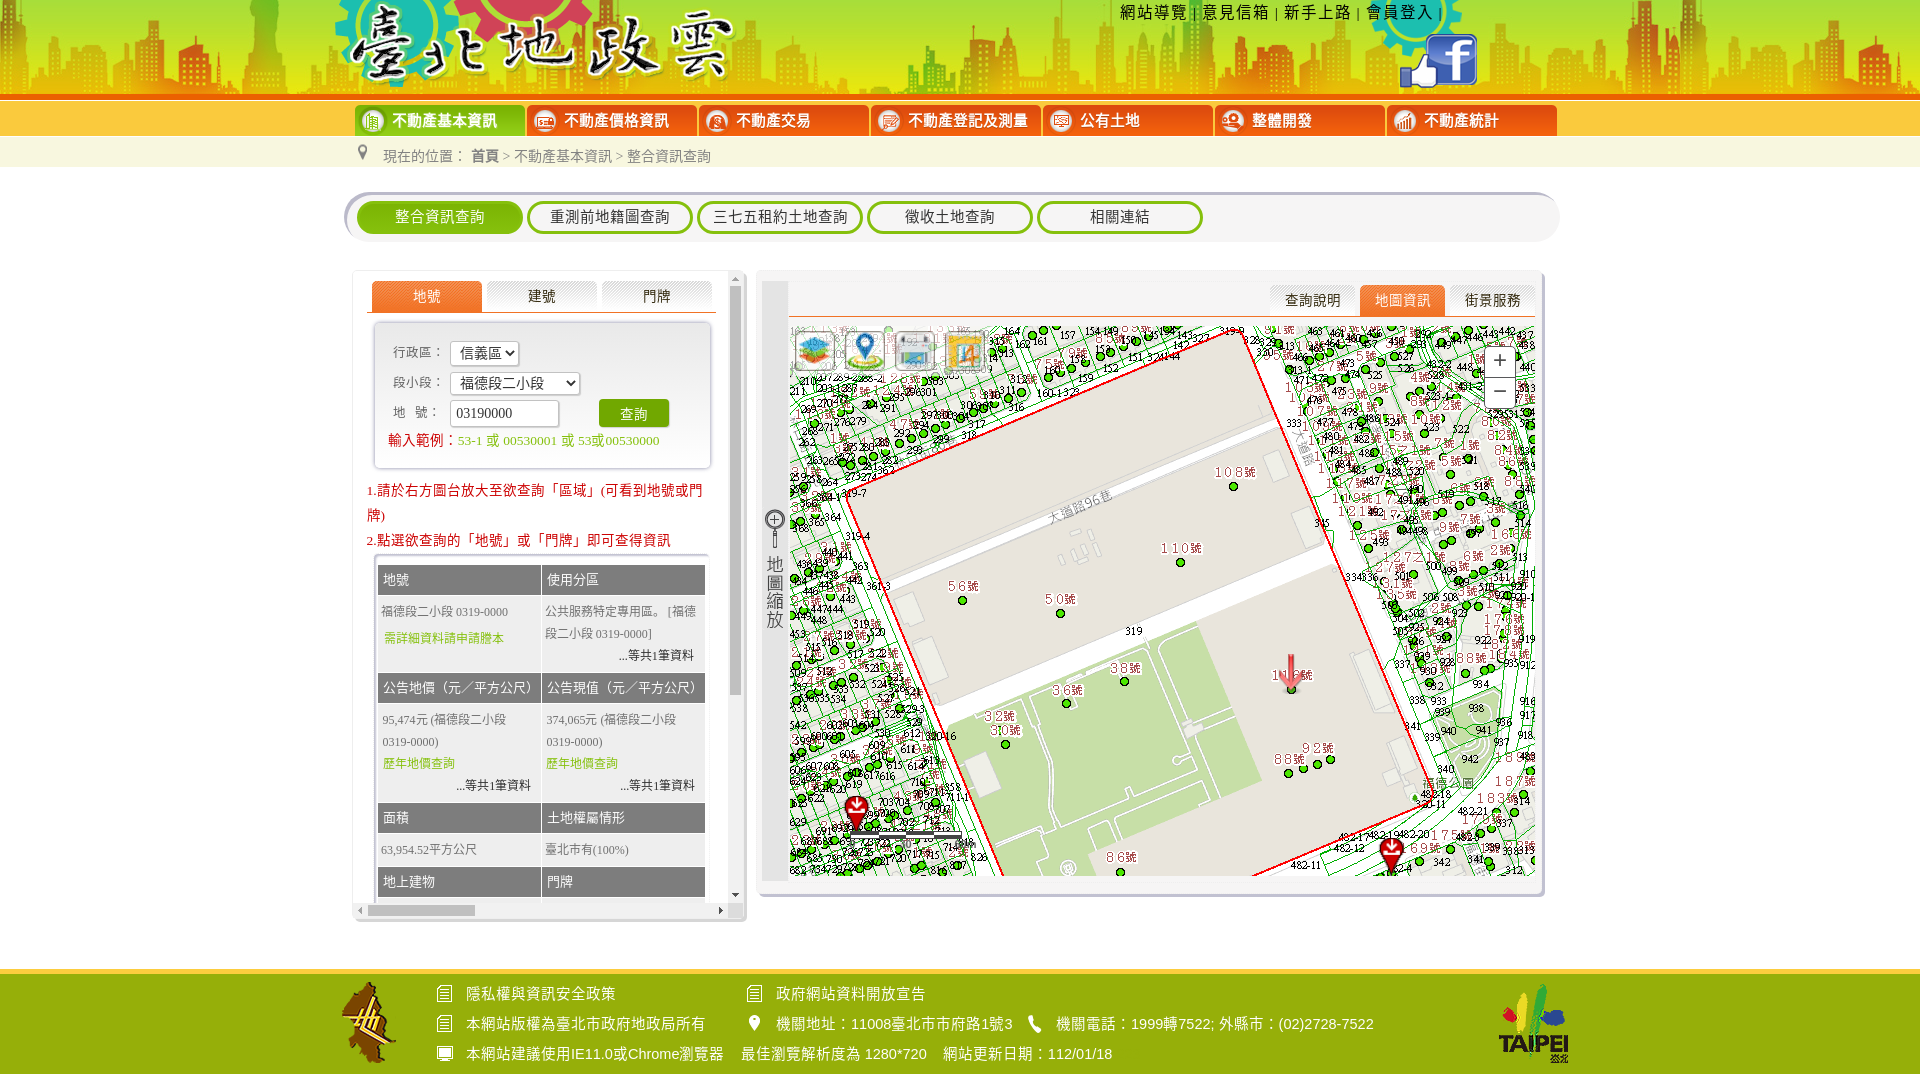

In [20]:
info = []

# 記下地段
select = Select(driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_LandNumber_ddl_SubGond'))
selected_option = select.first_selected_option
info.append(selected_option.text)

# 記下地號
land_num = driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_LandNumber_txt_LandNumber').get_attribute('value')
info.append(land_num)

# 記下面積
area = driver.find_element(By.ID, 'ContentPlaceHolder1_ContentPlaceHolder1_LandNumber_lbl_Area').text
info.append(area)

print(info)

driver.save_screenshot('result.png')
img = Image.open('result.png')
img

自動替所有地址抓下地段號

In [ ]:
#ids = driver.find_elements(By.XPATH, '//*[@id]')
#for idx, ii in enumerate(ids):
#    #print ii.tag_name
#    print(idx, ii.get_attribute('id')) 